In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from Bio import Phylo, SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats

# Read in dataframe containing monophyly information

In [90]:
monophyly_df = pd.read_csv('../Data/OMA_group_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
# monophyly_df = pd.read_csv('../Data/Tria_et_al_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
print(monophyly_df.shape)
monophyly_df.head(n=10)

(528, 9)


,monophyletic_clade,other_clade,root_bl,monophyletic_total_bl,other_total_bl,total_tree_bl,total_n,monophyletic_n,other_n
Group_id,,,,,,,,,
OMAGroup_789494,IntNode_3,IntNode_88,1.49293,69.00150,56.46590,126.96033,194.0,89.0,105.0
OMAGroup_556084,IntNode_63,IntNode_88,1.51192,45.38699,36.29295,83.19186,199.0,89.0,110.0
OMAGroup_555430,IntNode_46,IntNode_73,1.00116,30.16103,38.54124,69.70343,222.0,94.0,128.0
OMAGroup_828657,IntNode_43,IntNode_49,0.97504,16.43967,28.31956,45.73427,172.0,50.0,122.0
OMAGroup_804387,IntNode_48,IntNode_76,0.37875,20.59071,17.27605,38.24551,233.0,97.0,136.0
OMAGroup_832116,IntNode_88,IntNode_90,1.80966,32.08482,20.72547,54.61995,203.0,90.0,113.0
OMAGroup_809161,IntNode_3,IntNode_95,3.04869,32.59700,28.92590,64.57159,213.0,96.0,117.0
OMAGroup_839524,IntNode_42,IntNode_67,1.74309,17.51860,17.52166,36.78335,191.0,68.0,123.0
OMAGroup_840929,IntNode_65,IntNode_88,0.32456,17.32818,19.81383,37.46657,210.0,88.0,122.0


# Testing algorithm accuracies on full datasets

In [92]:
trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*Terms.Rooted.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.05*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.5*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.95*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/Tria_et_al_data/eukaryotes/processed_trees/*nwk.RootedNoZero.MPAJH'
# trees_dir = '../Data/Tria_et_al_data/eukaryotes/processed_trees/*Terms.Rooted.MPAJH'

methods = ['.MPAJH','.MinVarAJH', '.MADAJH']
# methods = ['.MPAJH',\
#            '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
#            '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH', '.MADweightControlAJH', '.MADweightTestyAJH']
# methods = ['.MPAJH',\
#            '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
#           '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
for method in methods:
    monophyly_df['{}_success'.format(method)] = np.nan

trees_tested = []

for tree_loc in glob.glob(trees_dir)[:]:
#     print(tree_loc)
    group = tree_loc.split('/')[-1].split('.')[0]
    if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
        continue
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        internals = [i.name for i in my_tree.get_nonterminals()]
        assert monophyly_df.loc[group]['monophyletic_clade'] in internals
        assert monophyly_df.loc[group]['other_clade'] in internals
        if monophyly_df.loc[group]['monophyletic_clade'] in [clade.name for clade in my_tree.root.clades] \
        and monophyly_df.loc[group]['other_clade'] in [clade.name for clade in my_tree.root.clades]:
            monophyly_df.set_value(group, '{}_success'.format(method), 1)
        else:
            monophyly_df.set_value(group, '{}_success'.format(method), 0)
    trees_tested.append(tree_loc)

In [93]:
for method in methods:
    print(method, '\t', monophyly_df['{}_success'.format(method)].sum())

.MPAJH 	 334.0
.MinVarAJH 	 399.0
.MADAJH 	 416.0


In [103]:
monophyly_df[monophyly_df['monophyletic_clade'].isnull()==False].shape

(514, 17)

In [104]:
416/514

0.8093385214007782

In [106]:
stats.fisher_exact([[416, 514-416], [399, 514-399]])

(1.2234668303411591, 0.21816902703598745)

In [101]:
monophyly_df.head()

,monophyletic_clade,other_clade,root_bl,monophyletic_total_bl,other_total_bl,total_tree_bl,total_n,monophyletic_n,other_n,.MPAJH_success,.MinVarAJH_success,.MinVarGSCAJH_success,.MinVarGSCnAJH_success,.MinVarHHAJH_success,.MADAJH_success,.MADweightAJH_success,.MADweightNormedAJH_success
Group_id,,,,,,,,,,,,,,,,,
OMAGroup_789494,IntNode_3,IntNode_88,1.49293,69.00150,56.46590,126.96033,194.0,89.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OMAGroup_556084,IntNode_63,IntNode_88,1.51192,45.38699,36.29295,83.19186,199.0,89.0,110.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
OMAGroup_555430,IntNode_46,IntNode_73,1.00116,30.16103,38.54124,69.70343,222.0,94.0,128.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
OMAGroup_828657,IntNode_43,IntNode_49,0.97504,16.43967,28.31956,45.73427,172.0,50.0,122.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
OMAGroup_804387,IntNode_48,IntNode_76,0.37875,20.59071,17.27605,38.24551,233.0,97.0,136.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN


# This only makes sense for non-pruned trees. 

But is a test of whether there is a statistical difference in the trees that one method gets right and another method gets wrong. I'm generally interested in whether methods are more robust to tree imbalance so the "statistical difference in the trees" that I'm caring about are essentialy the balance in terms of the number of taxa in the two monophyletic groups or the relative branch length of these two groups. 

In [137]:
testy = monophyly_df[(monophyly_df['.MADAJH_success']==0) & (monophyly_df['.MPAJH_success']==1)]
# res_a = testy['total_tree_bl']
###Look at branch length. If balanced, these would be 0.5
# res_a = testy['monophyletic_total_bl'] / (testy['total_tree_bl'] - testy['root_bl'])
###Look at taxa number, if balanced these would be 0.5 as well
###My instinct is that this is the most relevant thing to care about
res_a = testy['monophyletic_n'] / testy['total_n']
###Look at branch length per taxa. My instinct is that this is dumb
# res_a = (testy['monophyletic_total_bl']/testy['monophyletic_n']) /((testy['total_tree_bl']-testy['root_bl'])/testy['total_n'])
res_a

Group_id
OMAGroup_840929    0.419048
OMAGroup_837542    0.436242
OMAGroup_784475    0.371134
OMAGroup_745963    0.370370
OMAGroup_786887    0.396396
OMAGroup_840984    0.441860
OMAGroup_835263    0.444444
OMAGroup_781945    0.432558
OMAGroup_823988    0.454545
OMAGroup_825385    0.395480
OMAGroup_842254    0.474227
OMAGroup_833893    0.344086
OMAGroup_839846    0.452381
OMAGroup_555629    0.443243
OMAGroup_555704    0.424731
OMAGroup_838397    0.358696
OMAGroup_771547    0.329670
OMAGroup_781943    0.477157
OMAGroup_838637    0.352601
OMAGroup_781946    0.480000
OMAGroup_824237    0.438424
OMAGroup_555604    0.467033
OMAGroup_831785    0.475410
OMAGroup_788814    0.393939
OMAGroup_821886    0.470588
OMAGroup_783111    0.391304
dtype: float64

In [138]:
testy = monophyly_df[(monophyly_df['.MADAJH_success']==1) & (monophyly_df['.MPAJH_success']==0)]
# res_b = testy['total_tree_bl']
# res_b = testy['monophyletic_total_bl'] / (testy['total_tree_bl']-testy['root_bl'])
res_b = testy['monophyletic_n'] / testy['total_n']
# res_b = (testy['monophyletic_total_bl']/testy['monophyletic_n']) / ((testy['total_tree_bl']-testy['root_bl'])/testy['total_n'])
res_b

Group_id
OMAGroup_832116    0.443350
OMAGroup_837745    0.409091
OMAGroup_549030    0.411765
OMAGroup_813355    0.434579
OMAGroup_825335    0.340314
OMAGroup_711600    0.400000
OMAGroup_499157    0.405882
OMAGroup_841019    0.422727
OMAGroup_821345    0.447005
OMAGroup_840274    0.429319
OMAGroup_834727    0.448780
OMAGroup_555435    0.424779
OMAGroup_556019    0.491979
OMAGroup_555423    0.403587
OMAGroup_768309    0.351064
OMAGroup_664903    0.514286
OMAGroup_810533    0.379518
OMAGroup_826604    0.448780
OMAGroup_817985    0.457711
OMAGroup_833097    0.425234
OMAGroup_662668    0.413636
OMAGroup_839507    0.457447
OMAGroup_721452    0.465969
OMAGroup_555602    0.424419
OMAGroup_555550    0.435897
OMAGroup_825670    0.426606
OMAGroup_754919    0.655462
OMAGroup_826854    0.480000
OMAGroup_489860    0.340426
OMAGroup_555528    0.457831
                     ...   
OMAGroup_810040    0.436275
OMAGroup_801072    0.435407
OMAGroup_812374    0.377907
OMAGroup_732020    0.428571
OMAGroup_75

In [139]:
stats.ranksums(res_a.values, res_b.values),\
    np.median(res_a.values), np.median(res_b.values)

(RanksumsResult(statistic=0.52324867299322775, pvalue=0.60080121409847376),
 0.43439987513656936,
 0.42459868285655483)

In [140]:
stats.ranksums(np.abs(0.5-res_a.values), np.abs(0.5-res_b.values)),\
    np.median(np.abs(0.5-res_a.values)), np.median(np.abs(0.5-res_b.values)) 

(RanksumsResult(statistic=-0.70891755695856662, pvalue=0.47837563924795823),
 0.065600124863430642,
 0.076427061310782252)

(array([  2.,  12.,  17.,  14.,  18.,  16.,   8.,   8.,   8.,   5.]),
 array([ 0.30471931,  0.3511531 ,  0.3975869 ,  0.44402069,  0.49045448,
         0.53688828,  0.58332207,  0.62975586,  0.67618965,  0.72262345,
         0.76905724]),
 <a list of 10 Patch objects>)

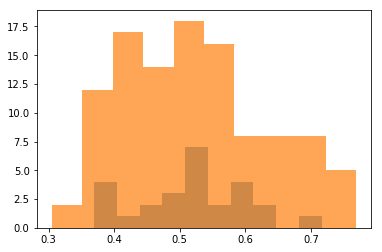

In [136]:
fig, ax = plt.subplots()
ax.hist(res_a.values, alpha=0.7)
ax.hist(res_b.values, alpha=0.7)
# ax.hist(np.abs(0.5-res_a.values), alpha=0.7)
# ax.hist(np.abs(0.5-res_b.values), alpha=0.7)

# Test variability/robustness in distance

In [ ]:
trees_dir = '../Data/raw_OMA_trees/*Rooted.MPAJH'
# trees_dir = '../Data/pruned_OMA_trees/*Rooted.MPAJH'
methods = ['.MPAJH', '.MLAJH', '.MADAJH']
accuracy_dict = {}
for method in methods:
    accuracy_dict[method] = []

trees_tested = []

for tree_loc in glob.glob(trees_dir)[:]:
    print(tree_loc)
    test_tree = Phylo.read(tree_loc, 'newick', rooted=True)
    testy = [term for term in test_tree.get_terminals() if\
                      term.name in metazoa]
    valid = is_monophyletic_all(test_tree.root, test_tree, testy, False)
    if valid == False:
        continue
        
    trees_tested.append(tree_loc)
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name in metazoa]
        non_metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name not in metazoa]

        if set(metazoa_clades) == set(my_tree.root.clades[0].get_terminals()) or \
            set(metazoa_clades) == set(my_tree.root.clades[1].get_terminals()):
            all_ca = my_tree.common_ancestor(non_metazoa_clades)
            accuracy_dict[method].append(my_tree.distance(all_ca, my_tree.root))

In [ ]:
fig, ax = plt.subplots()
ax.hist(accuracy_dict['.MPAJH'], alpha=0.2)
# ax.hist(accuracy_dict['.MLAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MADAJH'], alpha=0.2)

In [ ]:
trees_dir = '../Data/euk_trees/*Rooted.MPAJH'
ideal_species_n = 31

# trees_dir = '../Data/pruned_euk_trees/*_9_meta.nwk.Rooted.MPAJH'
# ideal_species_n = 22

# trees_dir = '../Data/pruned_euk_trees/*_12_meta.nwk.Rooted.MPAJH'
# ideal_species_n = 19


# methods = ['.MPAJH', '.MLAJH']
methods = ['.MPAJH', '.MLAJH', '.MADAJH']
accuracy_dict = {}
for method in methods:
    accuracy_dict[method] = []

trees_tested = []
for tree_loc in glob.glob(trees_dir)[:50]:
    print(tree_loc)
    test_tree = Phylo.read(tree_loc, 'newick', rooted=True)
    if len(test_tree.get_terminals()) != ideal_species_n:
        continue
    testy = [term for term in test_tree.get_terminals() if\
                      term.name in metazoa]
    valid = is_monophyletic_all(test_tree.root, test_tree, testy, False)
    if valid == False:
        continue
        
    trees_tested.append(tree_loc)
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name in metazoa]
        non_metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name not in metazoa]

        if set(metazoa_clades) == set(my_tree.root.clades[0].get_terminals()) or \
            set(metazoa_clades) == set(my_tree.root.clades[1].get_terminals()):
            all_ca = my_tree.common_ancestor(non_metazoa_clades)
            initial_dist = my_tree.distance(all_ca, my_tree.root)
        

            pruned_tree_loc = tree_loc.replace('/euk_trees/', '/pruned_euk_trees/')
            pruned_tree_loc = pruned_tree_loc.replace('.nwk.Rooted.MPAJH', '.pruned_9_meta.nwk.Rooted.MPAJH')
            pruned_tree_loc = pruned_tree_loc.replace('.MPAJH', method)
            pruned_tree = Phylo.read(pruned_tree_loc, 'newick', rooted=True)
            metazoa_clades = [term for term in pruned_tree.get_terminals() if\
                          term.name in metazoa]
            non_metazoa_clades = [term for term in pruned_tree.get_terminals() if\
                          term.name not in metazoa]

            if set(metazoa_clades) == set(pruned_tree.root.clades[0].get_terminals()) or \
                set(metazoa_clades) == set(pruned_tree.root.clades[1].get_terminals()):
                pruned_ca = pruned_tree.common_ancestor(non_metazoa_clades)
                pruned_dist = pruned_tree.distance(pruned_ca, pruned_tree.root)
#                 print(method, initial_dist, pruned_dist, initial_dist-pruned_dist)
#                 print(method, initial_dist-pruned_dist)
                accuracy_dict[method].append(initial_dist-pruned_dist)

In [ ]:
fig, ax = plt.subplots()
# ax.hist(accuracy_dict['.MPAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MLAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MADAJH'], alpha=0.2)